This notebook is used to estimate CGM mass (Eq 1, 2), escape velocity, etc. 

03/28/2019. YZ. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.constants as const
import matplotlib as mpl
mpl.rcParams['font.family'] = 'stixgeneral'

from astroquery.simbad import Simbad
gal_simbad = Simbad.query_object('DDO221') # WLM = DDO221
wlm_dist = 933 # kpc
wlm_coord = SkyCoord(ra=gal_simbad['RA'], dec=gal_simbad['DEC'], 
                     unit=(u.hourangle, u.degree), distance=wlm_dist*u.kpc)
wlm_l = wlm_coord.galactic.l.degree
wlm_b = wlm_coord.galactic.b.degree
wlm_ra = wlm_coord.icrs.ra.degree
wlm_dec = wlm_coord.icrs.dec.degree
wlm_rvir = 89.6*u.kpc # see the functions at the end of this notebook 
print('l = %.4f deg, b = %.4f deg'%(wlm_l, wlm_b))
print('ra = %.4f deg, dec = %.4f deg'%(wlm_ra, wlm_dec))

l = 75.8532 deg, b = -73.6258 deg
ra = 0.4912 deg, dec = -15.4639 deg


### CGM Silicon mass estimate, Equation 1

In [2]:
import numpy as np
import astropy.units as u
import astropy.constants as const

# component I 
nsi2 = 12.97
sig2 = 0.07

nsi3 = 13.36
sig3 = 0.08

nsi4 = 12.95
nsig4 = 0.07
# nsi_total = 10**nsi2 + 10**nsi3 + 10**nsi4

nsi_total = 10**13.6
print(np.log10(nsi_total))

13.6


In [3]:
rvir = 89.6*u.kpc
cf = 0.4 # from COS dwarfs
Msi = (np.pi*(rvir/2.)**2 * (nsi_total/u.cm**2) * const.m_p * 28).to(u.Msun).value * cf
print(Msi/1e4)

2.2516587212730794


### Use COS-dwarfs's density profile and covering fraction to infer the mass, Equation 2

In [4]:
from astropy.table import Table
costb = Table.read('tables/bordoloi14.txt', format='ascii')

cos_rfrac = costb['R']/costb['R_vir']
good = np.ones(len(costb))
good[costb['eN']<-100] = 0.

# for only detection 
temp = costb['logNCIV'][good == 1]
cosdwarf_logN = np.array([float(i) for i in temp])
cosdwarf_d = costb['R'][good == 1]
cosdwarf_rvir = costb['R_vir'][good == 1]
cosdwarf_rfrac = cosdwarf_d/cosdwarf_rvir

In [5]:
# bin the data 
bin_r = np.array([0.2, 0.4, 0.6])
bin_logN = np.zeros(len(bin_r))

ind = cosdwarf_rfrac<=bin_r[0]
bin_logN[0] = np.log10((10**cosdwarf_logN[ind]).mean())

ind = np.all([cosdwarf_rfrac<=bin_r[1], cosdwarf_rfrac>bin_r[0]], axis=0)
bin_logN[1] = np.log10((10**cosdwarf_logN[ind]).mean())

ind = np.all([cosdwarf_rfrac<=bin_r[2], cosdwarf_rfrac>bin_r[1]], axis=0)
bin_logN[2] = np.log10((10**cosdwarf_logN[ind]).mean())

-1.5747753584933326 14.528092472882387


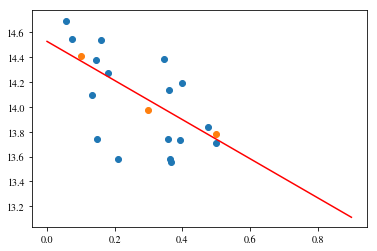

In [6]:
# let's do a simple fit 
civ_k, logN0 = np.polyfit(bin_r-0.1, bin_logN, 1)
print(civ_k, logN0)

plt.scatter(cosdwarf_rfrac, cosdwarf_logN)
plt.scatter(bin_r-0.1, bin_logN)

xx = np.mgrid[0:1.0:0.1]
plt.plot(xx, logN0+civ_k*xx, color='r')

In [7]:
# use the slop conver to SiIV 
Nsi_rfrac = 10**13.6
rfrac = 0.5
# civ_k  = -1.6
N0 = Nsi_rfrac/rfrac**civ_k
print(np.log10(N0))

13.125945380661006


In [8]:
# double check 
np.log10(N0*(rfrac**civ_k))

13.6

Now covering fraction 

In [9]:
from astropy.table import Table
costb = Table.read('tables/bordoloi14.txt', format='ascii')

cos_rfrac = costb['R']/costb['R_vir']
good = np.ones(len(costb))
good[costb['eN']<-100] = 0.

In [10]:
ind = cos_rfrac <= 1.2
temp = good[ind]
cf = temp[temp==1.].size/temp.size
print(cf, temp[temp==1.].size, temp.size)

0.3953488372093023 17 43


Covering profile 

In [11]:
rfrac = np.array([0.2, 0.4, 0.6, 0.8, 1.0])
cf = np.zeros(rfrac.size)

ind = cos_rfrac <= rfrac[0]
temp = good[ind]
cf[0] = temp[temp==1.].size/temp.size

ind = np.all([cos_rfrac <= rfrac[1], cos_rfrac > rfrac[0]], axis=0)
temp = good[ind]
cf[1] = temp[temp==1.].size/temp.size

ind = np.all([cos_rfrac <= rfrac[2], cos_rfrac > rfrac[1]], axis=0)
temp = good[ind]
cf[2] = temp[temp==1.].size/temp.size

ind = np.all([cos_rfrac <= rfrac[3], cos_rfrac > rfrac[2]], axis=0)
temp = good[ind]
cf[3] = temp[temp==1.].size/temp.size

ind = np.all([cos_rfrac <= rfrac[4], cos_rfrac > rfrac[3]], axis=0)
temp = good[ind]
cf[4] = temp[temp==1.].size/temp.size

print(cf)

[0.875      0.47058824 0.22222222 0.         0.        ]


In [12]:
rf_profile = np.mgrid[0.01:1.05:0.2]
cf_profile = np.zeros(rf_profile.size)
cf_profile[rf_profile<=rfrac[0]] = cf[0]
cf_profile[np.all([rf_profile>rfrac[0], rf_profile<=rfrac[1]], axis=0)] = cf[1]
cf_profile[np.all([rf_profile>rfrac[1], rf_profile<=rfrac[2]], axis=0)] = cf[2]
cf_profile[np.all([rf_profile>rfrac[2], rf_profile<=rfrac[3]], axis=0)] = cf[3]
cf_profile[np.all([rf_profile>rfrac[3], rf_profile<=rfrac[4]], axis=0)] = cf[4]

In [13]:
cf_profile

array([0.875     , 0.47058824, 0.22222222, 0.        , 0.        ,
       0.        ])

Mass calculation for Equation 2

In [14]:
Nr = 10**13.1 * rf_profile**(-1.6) / u.cm**2
rvir = 89.6*u.kpc
dr = 0.05 * u.kpc
Msi = np.sum(2*np.pi*rvir *dr * Nr * cf_profile * const.m_p * 28).to(u.Msun).value 
Msi / 1e5

1.1073311264263326

### SFH of WLM from Weisz+2014a Table 6

In [15]:
total_mass_formed = 8.63  # 2.54   4.49   2.38   6.73  
sfh_from_tb = '0.32 0.0  0.08 0.05 0.11 0.32 0.0  0.07 0.04 0.1  0.33 0.0  0.07 0.03 0.1  0.36 0.0  0.08 0.04 0.08 0.36 0.0  0.08 0.03 0.08 0.36 0.02 0.09 0.01 0.08 0.39 0.0  0.09 0.03 0.1  0.39 0.0  0.09 0.03 0.08 0.39 0.0  0.15 0.03 0.08 0.39 0.0  0.08 0.02 0.18 0.39 0.01 0.08 0.02 0.19 0.39 0.01 0.09 0.01 0.19 0.39 0.02 0.16 0.01 0.16 0.39 0.02 0.17 0.0  0.17 0.39 0.02 0.18 0.0  0.19 0.49 0.03 0.25 0.01 0.05 0.6  0.01 0.22 0.06 0.06 0.77 0.02 0.06 0.02 0.06 0.86 0.0  0.05 0.01 0.06 0.86 0.0 0.04 0.0  0.07 0.86 0.0 0.04 0.0  0.06 0.86 0.0 0.05 0.0  0.05 0.87 0.0 0.05 0.01 0.03 0.87 0.0  0.05 0.0  0.02 0.87 0.01 0.06 0.0  0.01 0.9  0.01 0.04 0.01 0.02 0.92 0.0 0.04 0.01 0.02 0.92 0.0 0.03 0.0  0.02 0.94 0.0 0.01 0.0  0.02 0.94 0.0 0.02 0.0  0.0  0.96 0.0 0.01 0.0  0.01 0.97 0.0 0.01 0.0  0.0  0.98 0.0 0.01 0.0  0.0  0.98 0.0 0.0  0.0  0.0  0.99 0.0 0.0  0.0  0.0  0.99 0.0 0.0  0.0  0.0  0.99 0.0 0.0  0.0  0.0  0.99 0.0 0.0  0.0  0.0  0.99 0.0 0.0  0.0  0.0  0.99 0.0  0.0  0.0  0.0  1.0  0.0 0.0 0.0  0.0  1.0  0.0 0.0 0.0  0.0  1.0  0.0 0.0 0.0  0.0  1.0  0.0 0.0 0.0  0.0  1.0 0.0 0.0 0.0  0.0  1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0'

In [16]:
sfh_str = sfh_from_tb.split()
sfh = np.asarray([np.float(i) for i in sfh_str[::5]])
sfh_sig_up = np.asarray([np.float(i) for i in sfh_str[2:][::5]])
sfh_sig_low = np.asarray([-np.float(i) for i in sfh_str[4:][::5]])

In [17]:
logt = np.concatenate([np.mgrid[6.6:8.7:0.1], np.mgrid[8.7:10.1:0.05]])[::-1] # see their paper on p8

In [18]:
# and the corresponding redshift for the lookback time 
from astropy.cosmology import Planck15
import scipy as sp

zs = np.mgrid[0:10:0.01]
lookback_time = Planck15.lookback_time(zs).value
z_wlm = np.interp(10**logt/1e9, lookback_time, zs)

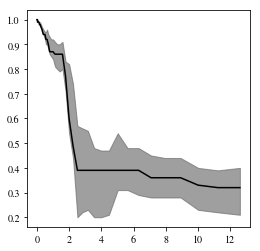

In [19]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.plot(10**logt/1e9, sfh, color='k')
ax.fill_between(10**logt/1e9, sfh+sfh_sig_up, sfh+sfh_sig_low, color=plt.cm.Greys(0.7), alpha=0.6)
#ax.xlim(12, 0)

#tax = ax.twiny()
#tax.plot(10**logt/1e9, sfh, color=None)
#tt = tax.set_xticks(z_wlm)

In [20]:
# the total amount of oxygen being produced, see Eq. 1 in McQuinn2015

Mtot_produced = 8.63*1e6 # by integrating the SFR, from Table 6 in Weisz+2014a
P = 0.00658  # the fraction of oxygen newly synthesized per solar mass
             # McQuinn+2015 adopted this value from Nomoto 2006
Moxy_produced = Mtot_produced*P 
print('Oxygen ever been synthesized: %.2e Msun'%(Moxy_produced))

Oxygen ever been synthesized: 5.68e+04 Msun


In [21]:
# the oxygen locked in stars, see Eq. 4 
log_OH = 8.69-12 # Asplund, 2009
x = 0.25
y = 0.75
mo_to_mp = 16
mH = 1
mHe = 4
log_zstar = log_OH + np.log10(mo_to_mp/(x*mH+y*mHe))

# oxygen mass locked in stars
R = 0.3 # oxygen recycling fraction 
Moxy_locked_star = (1-R) * Mtot_produced * 10**log_zstar
print('Oxygen locked in stars: %.2e Msun'%(Moxy_locked_star))

Oxygen locked in stars: 1.46e+04 Msun


In [22]:
# the oxygen in gas in the ISM, see Eq. 2 
log_OH_wlm = 7.83-12 # Lee+2005
Mhyd_wlm = 6.3e7 # kepley+2007
Moxy_gas = 10**log_OH_wlm * mo_to_mp * Mhyd_wlm
print('Oxygen in the gas: %.2e Msun'%(Moxy_gas))

Oxygen in the gas: 6.81e+04 Msun


In [23]:
Moxy_produced, Moxy_locked_star, Moxy_gas

(56785.4, 14566.17278919277, 68149.16391951178)

### Confirm isolation from Cetus

In [27]:
cetus_dist = 755 # kpc 
cetus_coord = SkyCoord(ra='00h26m11s', dec='−11d02m40s', unit=(u.hourangle, u.deg), distance=cetus_dist*u.kpc)
cetus_ra = cetus_coord.icrs.ra.degree
cetus_dec = cetus_coord.icrs.dec.degree
print('ra = %.4f deg, dec = %.4f deg'%(cetus_ra, cetus_dec))

# for cetus
cetus_rvir_deg = 4.6 # degree
cetus_rvir_coord = SkyCoord(ra=(cetus_ra+cetus_rvir_deg)*u.degree, 
                      dec=cetus_dec*u.degree, distance=cetus_dist*u.kpc, frame='icrs')
print('Virial radius(%.1f degree):'%(cetus_rvir_deg), cetus_coord.separation_3d(cetus_rvir_coord))

ra = 6.5458 deg, dec = -11.0444 deg
Virial radius(4.6 degree): 59.476645081195734 kpc


In [28]:
cetus_coord.separation_3d(wlm_coord)

<Distance [208.10286529] kpc>

### Stellar Mass, Halo Mass, Rvir, R200, and Escape Velocity 

Testing with the logMstar in Bordoloi+2014. 

The yztools package can be found on my github: https://github.com/yzhenggit/yzObs

In [29]:
from yzObs.calc_r200 import calc_r200, mstar_2_mhalo

mstar = 4.3e7 # msun  # Jackson+2007, Leaman+2012 
calc_r200(mstar = mstar)

logMh = 10.43 (2.7e+10) for logMstar = 7.63 (4.3e+07)

If use critical density, delta_c=rho/rho_c=200
r200 = 63.08 kpc

If use critical MATTER density, delta_c=rho/(rho_c*Omega_m)=200
r200 = 93.45 kpc



(<Quantity 63.07701166 kpc>, <Quantity 93.45217278 kpc>, 26775810497.60815)

Escape velocity 

In [8]:
import numpy as np
import astropy.units as u
import astropy.constants as const

def cal_Vesp(M_dm_Msun):
    G_cgs = const.G.to(u.cm**3/u.g/u.s**2)
    mass = M_dm_Msun*const.M_sun.to(u.g)# 5.5e10*const.M_sun.to(u.g)
    r = np.mgrid[0.1:300:0.1]*const.kpc.to(u.cm)
    vel_arr = np.sqrt(2*G_cgs*mass/r)
    
    return r, vel_arr

def cal_Vcirc_Vesp(M_dm_Msun, r):
    G_cgs = const.G.to(u.cm**3/u.g/u.s**2)
    mass = M_dm_Msun*const.M_sun.to(u.g)# 5.5e10*const.M_sun.to(u.g)
    r = r*const.kpc.to(u.cm)
    vcirc = np.sqrt(G_cgs*mass/r)
    vesp = np.sqrt(2*G_cgs*mass/r)
    return vcirc.to(u.km/u.s), vesp.to(u.km/u.s)


In [32]:
cal_Vcirc_Vesp(2.6e10, 90)

(<Quantity 35.24893206 km / s>, <Quantity 49.84951778 km / s>)

In [33]:
d = 1*u.Gyr * 20 * u.km/u.s
d.to(u.kpc)

<Quantity 20.4542433 kpc>

In [34]:
R_vir = 89.6
r, vel_arr = cal_Vesp(2.7e10)

Text(0, 0.5, 'Velocity (km/s)')

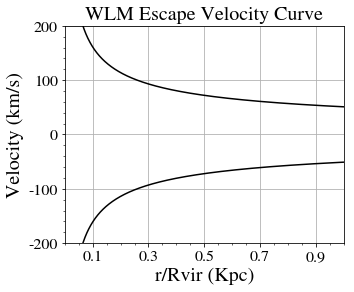

In [35]:
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
ax.plot(r.to(u.kpc)/R_vir, vel_arr.to(u.km/u.s), color='k')
ax.plot(r.to(u.kpc)/R_vir, -vel_arr.to(u.km/u.s), color='k')
ax.set_ylim(-200, 200)
ax.set_xlim(0, 1)
ax.set_yticks([-200, -100, 0, 100, 200])
ax.set_yticklabels(['-200', '-100', '0', '100', '200'], fontsize=16)
ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
ax.set_xticklabels(['0.1', '0.3', '0.5', '0.7', '0.9'], fontsize=16)
ax.grid()
ax.minorticks_on()
ax.set_title('WLM Escape Velocity Curve', fontsize=20)
ax.set_xlabel('r/Rvir (Kpc)', fontsize=20)
ax.set_ylabel('Velocity (km/s)', fontsize=20)